In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from unidecode import unidecode
from rapidfuzz import fuzz, process
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import itertools
from collections import Counter



In [2]:
df = pd.read_csv('Case2 - Dataset - DuplicatedProducts.csv')

df_copy = df.copy() 


In [3]:
df.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128038 entries, 0 to 128037
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            128038 non-null  int64 
 1   product_name          128038 non-null  object
 2   buy_unit              128038 non-null  object
 3   package               98588 non-null   object
 4   brand                 98610 non-null   object
 5   parent_category_id    128038 non-null  int64 
 6   category_id           128038 non-null  int64 
 7   parent_category_name  128038 non-null  object
 8   category_name         128038 non-null  object
 9   orders                128038 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 9.8+ MB


In [5]:
df.shape

(128038, 10)

In [6]:
df.describe()

,product_id,parent_category_id,category_id,orders
count,128038.000000,128038.000000,128038.000000,128038.000000
mean,64019.500000,570.146949,725.776535,500.239249
std,36961.531221,146.503819,461.820369,288.063852
min,1.000000,368.000000,1.000000,1.000000
25%,32010.250000,520.000000,244.000000,251.000000
50%,64019.500000,527.000000,872.000000,500.000000
75%,96028.750000,560.000000,996.000000,749.000000
max,128038.000000,1322.000000,1695.000000,1000.000000


In [7]:
#missing value check

df.isnull().sum()

product_id                  0
product_name                0
buy_unit                    0
package                 29450
brand                   29428
parent_category_id          0
category_id                 0
parent_category_name        0
category_name               0
orders                      0
dtype: int64

### Insights : Brand and package have missing values in them. 

In [8]:
df.sample(5) #Here i am checking some random rows to explore the dataset a bit more

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders
17845,17846,Pasabocas corn puffs,UN,Bolsa 255 g,Cheetos,518,996,"Dulces, snacks y galletas",Papas fritas y snacks,340
43176,43177,Preludyo pregabalina 75 mg,UN,14 cápsulas,Tecnoquimicas,585,869,Medicamentos,Neurológicos,546
32311,32312,Enciendefuegos Ecológicos X 24 Unidades,UN,NaN,Eco,526,1557,Hogar,Carbón y encendido,760
68646,68647,Dr. Clauders Bc Cachorro S M 20 Kg,UN,20 kg,Dr. Clauder's,528,230,Mascotas,Alimento seco,185
115263,115264,Set machacador y medidor tragos plateado,UN,Set 2 u,NaN,553,993,Decohogar,Bar,568


In [9]:
#Top brand and category

df['brand'].value_counts().head(10)


Miniso                3989
No-Varix              1210
Aro                   1019
Alkosto               1014
Vogue                  989
Euromax                587
Colsubsidio            558
Sempertex              540
Exito Marca Propia     488
Recovery               484
Name: brand, dtype: int64

### Insights : These are the top selling brands that have the highest products.

In [10]:

df['category_name'].value_counts().head(10)

Ortopedia                       3297
Alimento seco                   2463
Lociones y jabones              2265
Limpieza y cuidado cabello      2254
Verduras frescas                2026
Rostro                          1994
Cremas y tratamientos rostro    1820
Accesorios belleza              1623
Frutas frescas                  1604
Cuidados y mantenimiento        1584
Name: category_name, dtype: int64

### Insights : These are the top selling product category names that have the highest products.

In [11]:
# Spanish stopwords
spanish_stopwords = ["de","la","el","los","las","y","con","para","por","en","un","una","unos","unas","o","u","del","al"]

In [12]:
df.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259


In [13]:
text = (
    df['product_name'].fillna('') + ' ' +
    df['package'].fillna('') + ' ' +
    df['buy_unit'].fillna('')
)

combined_text = " ".join(text.astype(str).tolist())



In [14]:
#Using a regex to find the numbers & unit pattern 

pattern = r"\b\d+(?:[.,]\d+)?\s*(ml|l|lt|litro|litros|g|gr|gramos|kg|m|cm|mm|cc|oz|fl oz)\b"
matches = re.findall(pattern, combined_text, flags=re.IGNORECASE)


In [15]:
unique_units = sorted({m.lower() for m in matches})
print("Units found:", unique_units)

counts = Counter(m.lower() for m in matches)
print("\nUnit counts:")
for unit, count in counts.items():
    print(f"{unit}: {count}")


Units found: ['cc', 'cm', 'fl oz', 'g', 'gr', 'gramos', 'kg', 'l', 'litro', 'litros', 'lt', 'm', 'ml', 'mm', 'oz']

Unit counts:
g: 25991
gr: 6736
kg: 6074
ml: 22115
gramos: 575
m: 659
l: 2269
lt: 194
fl oz: 2
litros: 83
cc: 203
oz: 311
mm: 2047
cm: 4268
litro: 28


### Performing Normalization

Here in normalization, the goal is to make the products/units look alike. In other words we are cleaning the mess in this process and converting to lowercases and also getting rid of the accents that will help us understand and perform the analysis better.

In [16]:
#Units dictionary
unit_conversions = {
    'l': 1000, 'lt': 1000, 'litro': 1000, 'litros': 1000, 'cc': 1, 'ml': 1,
    'fl oz': 29.5735, 'kg': 1000, 'gramos': 1, 'gr': 1, 'g': 1, 'oz': 28.35,
    'cm': 0.01, 'mm': 0.001, 'm': 1
}

unit_pattern = re.compile(r'(\d+(?:[.,]\d+)?)\s*(' + '|'.join(unit_conversions) + r')\b')


In [17]:
#Function to remove accents

def remove_accents(s):
    return ''.join(word for word in unicodedata.normalize('NFKD', s) if not unicodedata.combining(word))

In [18]:
#Function to clean product name and normalize it

def cleaned_prod_name(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return ""

    text = text.lower()

    def convert(m):
        val = float(m.group(1).replace(',', '.'))
        unit = m.group(2)
        x = val * unit_conversions[unit]
        if unit in ('l', 'lt', 'litro', 'lts','litros', 'cc', 'ml', 'fl oz'):
            return f"{int(round(x))} ml"
        elif unit in ('kg', 'gramos', 'kgs','grs', 'gr', 'g', 'oz'):
            return f"{int(round(x))} g"
        return f"{x:g} m"
    
    text = unit_pattern.sub(convert, text)
    text = remove_accents(text)
    tokens = [word for word in re.findall(r'[a-z0-9]+', text) if word not in spanish_stopwords]
    return " ".join(tokens)

In [19]:
print(df.columns.to_list())

['product_id', 'product_name', 'buy_unit', 'package', 'brand', 'parent_category_id', 'category_id', 'parent_category_name', 'category_name', 'orders']


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128038 entries, 0 to 128037
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            128038 non-null  int64 
 1   product_name          128038 non-null  object
 2   buy_unit              128038 non-null  object
 3   package               98588 non-null   object
 4   brand                 98610 non-null   object
 5   parent_category_id    128038 non-null  int64 
 6   category_id           128038 non-null  int64 
 7   parent_category_name  128038 non-null  object
 8   category_name         128038 non-null  object
 9   orders                128038 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 9.8+ MB


In [21]:
df["product_name_normalized"] = df["product_name"].apply(cleaned_prod_name)

df[["product_name", "product_name_normalized"]].head(20)


,product_name,product_name_normalized
0,Atún en aceite,atun aceite
1,Atún en aceite,atun aceite
2,Atún en aceite de girasol,atun aceite girasol
3,Atún en agua,atun agua
4,Atún en agua,atun agua
5,Atún en agua,atun agua
6,Atún en agua con limón,atun agua limon
7,Atún en aceite de girasol,atun aceite girasol
8,Atún en aceite,atun aceite
9,Atún Van Camps Lomitos En,atun van camps lomitos


In [22]:
clean_pct = 100 - (df['product_name_normalized'].str.contains(r'\b(l|lt|litro|litros|ml|cc|kg|g|gramos|gr|cm|mm|oz|fl oz)\b', 
                case=False).sum() 
                                                              
/ len(df) * 100)

print(f"Cleaned: {clean_pct:.2f}% |  Not Cleaned: {100-clean_pct:.2f}%")


Cleaned: 88.68% |  Not Cleaned: 11.32%


/var/folders/3m/1wx78k796rsbtb7rg5bl8mp00000gn/T/ipykernel_94477/2584189495.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  clean_pct = 100 - (df['product_name_normalized'].str.contains(r'\b(l|lt|litro|litros|ml|cc|kg|g|gramos|gr|cm|mm|oz|fl oz)\b',


In [23]:
df.head(20)

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262,atun aceite
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387,atun aceite
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749,atun agua
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259,atun agua
5,6,Atún en agua,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,384,atun agua
6,7,Atún en agua con limón,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,81,atun agua limon
7,8,Atún en aceite de girasol,UN,160 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,597,atun aceite girasol
8,9,Atún en aceite,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,914,atun aceite
9,10,Atún Van Camps Lomitos En,UN,NaN,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,777,atun van camps lomitos


### Converting all the 11% of uncleaned normalized data

In [24]:
unit_conversions_updated = {
    'l': 1000, 'lt': 1000, 'litro': 1000, 'litros': 1000, 'lts': 1000,
    'cc': 1, 'ml': 1, 'fl oz': 29.5735, 'floz': 29.5735, 'fl-oz': 29.5735,
    'kg': 1000, 'kgs': 1000, 'gramos': 1, 'gr': 1, 'grs': 1, 'g': 1,
    'oz': 28.35, 'lb': 453.59, 'lbs': 453.59,
    'cm': 0.01, 'mm': 0.001, 'm': 1
}

sorted_units = sorted(unit_conversions_updated.keys(), key=len, reverse=True)
unit_pattern_str = '|'.join(map(re.escape, sorted_units))

# Pattern for single measurements
single_measure_pattern = re.compile(
    rf'(?i)(\d+(?:[.,]\d+)?)(?:\s*)({unit_pattern_str})\.?\b'
)

# Measure pattern for multipacks 
multi_measure_pattern = re.compile(
    rf'(?i)\b(\d+)\s*[x*]\s*(\d+(?:[.,]\d+)?)(?:\s*)({unit_pattern_str})\.?\b'
)

def clean_measure_text(text):
    """Normalize measurement units within product descriptions."""
    if not isinstance(text, str) or not text.strip():
        return text

#Converting to lowercases
    line = text.lower()

#Normalizing the units
    line = re.sub(r'\bfl\.?\s*oz\b', 'fl oz', line)   # fl. oz / floz -> fl oz
    line = re.sub(r'\bfl[-\s]?oz\b', 'fl oz', line)   # fl-oz -> fl oz
    line = line.replace('×', 'x')              
    line = line.replace('½', '0.5').replace('¼', '0.25').replace('¾', '0.75')

    #function to handle multipacks
    def pack_replace(match):
        qty = int(match.group(1))
        amount = float(match.group(2).replace(',', '.'))
        unit = match.group(3)
        total_value = amount * unit_conversions_updated[unit]
        if unit in ('l','lt','litro','litros','lts','cc','ml','fl oz','floz','fl-oz'):
            return f"{int(round(qty * total_value))} ml"
        elif unit in ('kg','kgs','gramos','gr','grs','g','oz','lb','lbs'):
            return f"{int(round(qty * total_value))} g"
        else:
            return f"{qty * total_value:g} m"

    line = multi_measure_pattern.sub(pack_replace, line)

    #function to handle single packs
    def single_replace(match):
        amount = float(match.group(1).replace(',', '.'))
        unit = match.group(2)
        total_value = amount * unit_conversions_updated[unit]
        if unit in ('l','lt','litro','litros','lts','cc','ml','fl oz','floz','fl-oz'):
            return f"{int(round(total_value))} ml"
        elif unit in ('kg','kgs','gramos','gr','grs','g','oz','lb','lbs'):
            return f"{int(round(total_value))} g"
        else:
            return f"{total_value:g} m"

    return single_measure_pattern.sub(single_replace, line)


In [25]:
clean_pct = 100 - (df['product_name_normalized'].str.contains(r'\b(l|lt|litro|litros|cc|fl oz|kg|gramos?|grs?|gr|oz|mm|cm)\b', case=False).sum() / len(df) * 100)
print(f" Cleaned: {clean_pct:.2f}% &  Not Cleaned: {100-clean_pct:.2f}%")


/var/folders/3m/1wx78k796rsbtb7rg5bl8mp00000gn/T/ipykernel_94477/2357401318.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  clean_pct = 100 - (df['product_name_normalized'].str.contains(r'\b(l|lt|litro|litros|cc|fl oz|kg|gramos?|grs?|gr|oz|mm|cm)\b', case=False).sum() / len(df) * 100)


 Cleaned: 99.00% &  Not Cleaned: 1.00%


### Insights: This shows that the normalization process is completed as we have got a cleaned data%. 

## Standardization

In [26]:
def standardize_product_name(name):
    if not isinstance(name, str):
        return ""
    
    name = name.lower()
    name = unidecode(name)
    
    # Replacing punctuation or special chars with space
    name = re.sub(r"[^a-z0-9\s]", " ", name)
    
    #Converting the units to standard (volume → ml, weight → g)
    name = re.sub(r"(\d+(?:\.\d+)?)\s*l\b",  lambda m: f"{int(round(float(m.group(1))*1000))} ml", name)
    name = re.sub(r"(\d+(?:\.\d+)?)\s*cc\b", lambda m: f"{int(round(float(m.group(1))))} ml", name)
    name = re.sub(r"(\d+(?:\.\d+)?)\s*kg\b", lambda m: f"{int(round(float(m.group(1))*1000))} g", name)
    name = re.sub(r"(\d+(?:\.\d+)?)\s*(g|gr|gramos)\b", lambda m: f"{int(round(float(m.group(1))))} g", name)

    words = [word for word in name.split() if word not in spanish_stopwords]
    name = " ".join(words)
    
    return name

df['product_name_std'] = df['product_name'].apply(standardize_product_name)
df[['product_name', 'product_name_std']].head(10)

,product_name,product_name_std
0,Atún en aceite,atun aceite
1,Atún en aceite,atun aceite
2,Atún en aceite de girasol,atun aceite girasol
3,Atún en agua,atun agua
4,Atún en agua,atun agua
5,Atún en agua,atun agua
6,Atún en agua con limón,atun agua limon
7,Atún en aceite de girasol,atun aceite girasol
8,Atún en aceite,atun aceite
9,Atún Van Camps Lomitos En,atun van camps lomitos


In [27]:
print("Total products:", len(df))
print("Unique product_name before:", df['product_name'].nunique())
print("Unique product_name after:", df['product_name_std'].nunique())

y = df['product_name'].fillna('').astype(str) == df['product_name_std'].fillna('').astype(str)

already_standardized = int(y.sum()); changed_after = len(df) - already_standardized
print(f"Already standardized before: {already_standardized} ({already_standardized/len(df):.2%})")
print( f"Standardized after (changed): {changed_after} ({changed_after/len(df):.2%})")


#Uppercase check
uppercase_left = df[df['product_name_std'].str.contains(r'[A-Z]')]
print("Rows with uppercase left:", len(uppercase_left))


accents_left = df[df['product_name_std'] != df['product_name_std'].apply(unidecode)]
print("Rows with accents left:", len(accents_left))


# Adidng a list of stopwords here that were previously not added

stopwords = {"caja", "pack", "botella"}
stopwords_left = df[df['product_name_std'].apply(lambda x: any(word in x.split() for word in stopwords))]
print("Rows with stopwords left:", len(stopwords_left))

df[['product_name', 'product_name_std']].sample(10)


Total products: 128038
Unique product_name before: 107375
Unique product_name after: 104429
Already standardized before: 75 (0.06%)
Standardized after (changed): 127963 (99.94%)
Rows with uppercase left: 0
Rows with accents left: 0
Rows with stopwords left: 3629


,product_name,product_name_std
46098,Pate De Queso Surtido,pate queso surtido
119457,Ofta Top Terra Liqx3000Ml+Quitamp.Es,ofta top terra liqx3000ml quitamp es
61141,Lehit coctel multivitaminico repolarizador 8 e...,lehit coctel multivitaminico repolarizador 8 1...
59233,Mezcla en polvo bebida,mezcla polvo bebida
83560,Sombra para ojos monocromatica #33 color me,sombra ojos monocromatica 33 color me
51708,Crema Arrurrú natural ligera hipoalergénica,crema arrurru natural ligera hipoalergenica
108000,Silver magnum confetti bouquet x7,silver magnum confetti bouquet x7
86864,"Bisagra 3"" T1322-001 Bolsa x3und",bisagra 3 t1322 001 bolsa x3und
13815,Tinte tono 28,tinte tono 28
9739,Nuggets,nuggets


#### Insight: We cleaned and standardized product names across 128k catalog items. This removed case, accents, stopwords, and normalized units which is crucial before performing any duplication steps. This preprocessing step reduced unique names by ~3%, creating a consistent baseline that is crucial for accurately identifying and classifying duplicates in the next stage.

In [28]:
stopwords_found = {
    sw: df["product_name_std"].str.contains(rf"\b{sw}\b", regex=True).sum()
    for sw in stopwords
}

stopwords_found

{'caja': 1954, 'botella': 649, 'pack': 1069}

In [29]:
def standardize_package(packages):
    if not isinstance(packages, str) or not packages.strip():
        return ""
    
    standardization = unidecode(packages.lower()) #Converting the package column to lowercase
    
    #cleanups below
    standardization = re.sub(r"(\d),(\d)",r"\1.\2", standardization)
    standardization = re.sub(r'["“”′″\'’]', "", standardization) 
    standardization = re.sub(r"(?<=\d)\s*[x×]\s*(?=\d)", " x ", standardization)  
    standardization = re.sub(r'\(\s*(ml|l|lt|lts|ltr|ltrs|litro|litros|cc|kg|kgs|kilo|kilos|g|gr|grs|gramo|gramos)\s*\)', r' \1', standardization)
    standardization = re.sub(r"\bc\s*/\s*u\b", "c/u", standardization) 
    standardization = re.sub(r"(\d+(?:\.\d+)?)(ml|l|lt|lts|ltr|ltrs|litro|litros|cc|kg|kgs|kilo|kilos|g|gr|grs|gramo|gramos)\b", r"\1 \2", standardization)
    standardization = re.sub(r"\b(unidad(?:es)?|unid|und|u)\b", "un", standardization)
    
    #Dimension check
    dimensions = bool(re.search(r'\b\d+(?:\.\d+)?\s*[lwh]\b(?:\s*x\s*\d+(?:\.\d+)?\s*[lwh]\b){1,}', standardization))
    litres_types = r"(?:lt|lts|ltr|ltrs|litro|litros)" if dimensions else r"(?:l|lt|lts|ltr|ltrs|litro|litros)"

    #Unit conversions
    unitconversions = [
        (rf"(\d+(?:\.\d+)?)\s*{litres_types}\b", lambda m: f"{int(round(float(m.group(1)) * 1000))} ml"),
        (r"(\d+(?:\.\d+)?)\s*cc\b", lambda m: f"{int(round(float(m.group(1))))} ml"),
        (r"(\d+(?:\.\d+)?)\s*(kg|kgs|kilo|kilos)\b", lambda m: f"{int(round(float(m.group(1)) * 1000))} g"),
        (r"(\d+(?:\.\d+)?)\s*(g|gr|grs|gramo|gramos)\b", lambda m: f"{int(round(float(m.group(1))))} g")]

    for x, y in unitconversions:
        standardization = re.sub(x, y, standardization)

    standardization = re.sub(r"[^a-z0-9\s/x.]", " ", standardization)
    standardization = " ".join(standardization.split())
    return standardization


df["package_std"] = df["package"].apply(standardize_package)

In [30]:
def package_std_results(df, x='package', std='package_std', sample_n=8):
    total = len(df)
    
    y = df[x].fillna('') == df[std].fillna('')
    already_standardized = int(y.sum())   # rows that were already clean
    stanrdized_count = int(total - already_standardized)  # rows that changed after cleaning

    uppercases_remaining = df[std].str.contains(r'[A-Z]', na=False).sum()
    accents_remaining = (df[std] != df[std].astype(str).apply(unidecode)).sum()

    units_standardized = r'\b\d+(?:\.\d+)?\s*(?:l|lt|lts|ltr|ltrs|litro|litros|cc|kg|kgs|kilo|kilos|gr|grs|gramo|gramos)\b'
    checker = df[df[std].str.contains(units_standardized, na=False, regex=True)].index

    print(f"Rows: {total:}")
    print(f"Standardized words that were changed : {stanrdized_count:} ({stanrdized_count/total:.2%})")
    print(f"Already standardized before: {already_standardized:} ({already_standardized/total:.2%})")
    print(f"uppercase words remaining: {uppercases_remaining}")
    print(f"accent words remaining : {accents_remaining}")
    print(f"# of units remaining: {len(checker)}")

    if uppercases_remaining == 0 and accents_remaining == 0 and len(checker) == 0:
        print("\n Output: No units left to be standardized.")
    else:
        print("\n Remaining Table:")
        display(df.loc[checker, [x, std]].head(sample_n))

package_std_results(df)

Rows: 128038
Standardized words that were changed : 70327 (54.93%)
Already standardized before: 57711 (45.07%)
uppercase words remaining: 0
accent words remaining : 0
# of units remaining: 2

 Remaining Table:


,package,package_std
502,Bolsa 8(Kg,bolsa 8 kg
36003,"2.51""L x 2.73""W x 0.69""H",2.51 l x 2.73w x 0.69h


In [31]:
remaining_accent_words = df['package_std'].apply(lambda s: isinstance(s, str) and s != unidecode(s))
print("Accents left:", remaining_accent_words.sum())

df.loc[remaining_accent_words, ['package','package_std']].head(3)

Accents left: 0


,package,package_std


### Insight: Standardization of package is done

## Brand Standardization

In [32]:
def brand_standardize(b):
    if not isinstance(b, str) or not b.strip():
        return ""
    s = unidecode(b.lower())

    #replacing & with and
    s = s.replace("&", " and ")

    # Replacing all characyers with space
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    
    # collapse spaces
    s = " ".join(s.split())
    return s

df["brand_std"] = df["brand"].apply(brand_standardize)


In [33]:
print("Total rows:", len(df))
print("Unique brand before:", df["brand"].nunique())
print("Unique brand after :", df["brand_std"].nunique())

y = df['brand'].fillna('').astype(str) == df['brand_std'].fillna('').astype(str)

already_standardized = int(y.sum()); changed_after = len(df) - already_standardized
print(f"Already standardized before: {already_standardized} ({already_standardized/len(df):.2%})")
print( f"Standardized after (changed): {changed_after} ({changed_after/len(df):.2%})")


# Uppercase remaining in our data
upper_left = df[df["brand_std"].str.contains(r"[A-Z]", na=False)]
print("Rows with uppercase left:", len(upper_left))

# Accents remaining in our data
accents_left = df[df["brand_std"] != df["brand_std"].apply(unidecode)]
print("Rows with accents left:", len(accents_left))

df[["brand", "brand_std"]].sample(5, random_state=42)


Total rows: 128038
Unique brand before: 8717
Unique brand after : 8504
Already standardized before: 29934 (23.38%)
Standardized after (changed): 98104 (76.62%)
Rows with uppercase left: 0
Rows with accents left: 0


,brand,brand_std
87523,Treker,treker
13816,Koleston,koleston
95955,No-Varix,no varix
25417,Malt-O-Meal,malt o meal
57958,La Tipica,la tipica


### Category standardization

In [34]:
def standardize_category(category):
    if not isinstance(category, str) or not category.strip():
        return ""
    category_stdardized = unidecode(category.lower()).strip()
    category_stdardized = re.sub(r'\s+', ' ', category_stdardized)
    return category_stdardized

In [35]:
df["category_std"] = df["category_name"].apply(standardize_category)


In [36]:
print("Total rows:", len(df))
print("Unique category before:", df["category_name"].nunique())
print("Unique category after :", df["category_std"].nunique())

upper_case_categories = df[df["category_std"].str.contains(r"[A-Z]", na=False)]
print("Rows with uppercase remaining:", len(upper_case_categories))

accents_categories = df[df["category_std"] != df["category_std"].apply(unidecode)]
print("Rows with accents left:", len(accents_categories))

y = df['category_name'].fillna('').astype(str) == df['category_std'].fillna('').astype(str)

already_standardized = int(y.sum()); changed_after = len(df) - already_standardized
print(f"Already standardized before: {already_standardized} ({already_standardized/len(df):.2%})")
print( f"Standardized after (changed): {changed_after} ({changed_after/len(df):.2%})")



df[["category_name", "category_std"]].sample(10, random_state=42)

Total rows: 128038
Unique category before: 767
Unique category after : 766
Rows with uppercase remaining: 0
Rows with accents left: 0
Already standardized before: 0 (0.00%)
Standardized after (changed): 128038 (100.00%)


,category_name,category_std
87523,Fijaciones,fijaciones
13816,"Coloración, decoloración y accesorios","coloracion, decoloracion y accesorios"
95955,Ortopedia,ortopedia
25417,Cereales,cereales
57958,Tortillas,tortillas
88126,Sillas y pisos,sillas y pisos
65660,Alimento seco,alimento seco
11469,Malbec,malbec
122027,"Botellas, termos y mugs","botellas, termos y mugs"
18122,Labios,labios


In [37]:
# Fixing the rows with uppercase

df['category_std'] = df['category_std'].apply(lambda x: x.lower() if isinstance(x,str) else x)


In [38]:
# Fixing the rows with accents

df['category_std'] = df['category_std'].apply(lambda x: unidecode(x) if isinstance(x,str) else x)


In [39]:
print("Total rows:", len(df))
print("Unique category before:", df["category_name"].nunique())
print("Unique category after :", df["category_std"].nunique())

upper_case_categories = df[df["category_std"].str.contains(r"[A-Z]", na=False)]
print("Rows with uppercase remaining:", len(upper_case_categories))

accents_categories = df[df["category_std"] != df["category_std"].apply(unidecode)]
print("Rows with accents left:", len(accents_categories))

Total rows: 128038
Unique category before: 767
Unique category after : 766
Rows with uppercase remaining: 0
Rows with accents left: 0


### Finding similarity score

In [40]:
#Creating a canonical name column from all the standardized columns
df['canonical_name'] = (
    df['brand_std'].fillna('') + ' ' +
    df['product_name_std'].fillna('') + ' ' +
    df['package_std'].fillna('')
)

df['canonical_name'] = df['canonical_name'].str.strip().str.replace(r'\s+', ' ', regex=True)

display(df[['product_name', 'canonical_name']].head())

,product_name,canonical_name
0,Atún en aceite,van camp s atun aceite 3 un x 160 g c/un
1,Atún en aceite,van camp s atun aceite 1730 g
2,Atún en aceite de girasol,van camp s atun aceite girasol 4 un x 160 g c/un
3,Atún en agua,van camp s atun agua 6 un x 160 g c/un
4,Atún en agua,van camp s atun agua 3 un x 80 g c/un


In [41]:
query_product = df.loc[5, 'canonical_name']
print(f"Finding matches for: '{query_product}' ---")


entire_dataset_names = df['canonical_name'].tolist()

top_matches = process.extract(query_product, entire_dataset_names, limit=5, scorer=fuzz.token_sort_ratio)

print("\nTop 5 most similar products found:")
for match, score, index in top_matches:
    print(f" The Similarity Score is : {score:.2f} for Match: '{match}' (at index {index})")

Finding matches for: 'van camp s atun agua 4 un x 160 g c/un' ---

Top 5 most similar products found:
 The Similarity Score is : 100.00 for Match: 'van camp s atun agua 4 un x 160 g c/un' (at index 5)
 The Similarity Score is : 97.37 for Match: 'van camp s atun agua 6 un x 160 g c/un' (at index 3)
 The Similarity Score is : 93.33 for Match: 'van camp s atun agua 6 un x 80 g c/un' (at index 35)
 The Similarity Score is : 90.67 for Match: 'van camp s atun agua 3 un x 80 g c/un' (at index 4)
 The Similarity Score is : 90.14 for Match: 'van camp s atun agua 3 un x 160 g' (at index 17)


In [42]:
example_index = 500
query_product_original = df.loc[example_index, 'product_name']
query_product_canonical = df.loc[example_index, 'product_name_std']

all_names = df['product_name_std'].tolist()

top_matches = process.extract(
    query_product_canonical,
    all_names,
    limit=2,
    scorer=fuzz.token_sort_ratio
)

best_match_canonical, score, best_match_index = top_matches[1]
best_match_original = df.loc[best_match_index, 'product_name']


print("--- A Pair of Almost Identical Products ---")

print("\nPRODUCT 1:")
print(f"  - Original Name: '{query_product_original}'")
print(f"  - Canonical Name: '{query_product_canonical}'")

print("\nPRODUCT 2 (Closest Match Found):")
print(f"  - Original Name: '{best_match_original}'")
print(f"  - Canonical Name: '{best_match_canonical}'")

print(f"\nSimilarity Score: {score:.2f}")

--- A Pair of Almost Identical Products ---

PRODUCT 1:
  - Original Name: 'Dog Chow Cachorros Pequeños 17 Kg'
  - Canonical Name: 'dog chow cachorros pequenos 17000 g'

PRODUCT 2 (Closest Match Found):
  - Original Name: 'Dog Chow Cachorros Pequeños 1 Kg'
  - Canonical Name: 'dog chow cachorros pequenos 1000 g'

Similarity Score: 98.55


In [43]:
def similarity_score(a: str, b: str) -> int:
    return int(fuzz.token_set_ratio(a, b))

In [44]:
def confidence_bucket(s: int) -> str:
    if s > 95:
        return "High"
    elif s >= 75:
        return "Medium"
    else:
        return "Low"

In [45]:
def confidence_score_col(c: str) -> str:
    return {
        "High":   "Auto-merge as duplicate",
        "Medium": "Send to manual review",
        "Low":    "Treat as unique / ignore"
    }[c]


In [46]:
df["similarity_score"] = df.apply(
    lambda r: similarity_score(r["product_name"], r["product_name_std"]), axis=1
)

In [47]:
df.head(10)

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,canonical_name,similarity_score
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262,atun aceite,atun aceite,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite 3 un x 160 g c/un,72
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387,atun aceite,atun aceite,1730 g,van camp s,carnes y mariscos en conserva,van camp s atun aceite 1730 g,72
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol,atun aceite girasol,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite girasol 4 un x 160 g c/un,84
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749,atun agua,atun agua,6 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 6 un x 160 g c/un,66
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259,atun agua,atun agua,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 3 un x 80 g c/un,66
5,6,Atún en agua,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,384,atun agua,atun agua,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 4 un x 160 g c/un,66
6,7,Atún en agua con limón,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,81,atun agua limon,atun agua limon,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua limon 3 un x 80 g c/un,64
7,8,Atún en aceite de girasol,UN,160 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,597,atun aceite girasol,atun aceite girasol,160 g,van camp s,carnes y mariscos en conserva,van camp s atun aceite girasol 160 g,84
8,9,Atún en aceite,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,914,atun aceite,atun aceite,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite 3 un x 80 g c/un,72
9,10,Atún Van Camps Lomitos En,UN,NaN,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,777,atun van camps lomitos,atun van camps lomitos,,van camp s,carnes y mariscos en conserva,van camp s atun van camps lomitos,72


In [48]:
df["Bucket_Type"] = df["similarity_score"].apply(confidence_bucket)
df.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,canonical_name,similarity_score,Bucket_Type
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262,atun aceite,atun aceite,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite 3 un x 160 g c/un,72,Low
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387,atun aceite,atun aceite,1730 g,van camp s,carnes y mariscos en conserva,van camp s atun aceite 1730 g,72,Low
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol,atun aceite girasol,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite girasol 4 un x 160 g c/un,84,Medium
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749,atun agua,atun agua,6 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 6 un x 160 g c/un,66,Low
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259,atun agua,atun agua,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 3 un x 80 g c/un,66,Low


In [56]:
df["Action"] = df["Bucket_Type"].apply(confidence_score_col)

filtered_df = df[df['Bucket_Type'] == 'Medium']
filtered_df.head(10)

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,canonical_name,similarity_score,Bucket_Type,Action
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol,atun aceite girasol,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite girasol 4 un x 160 g c/un,84,Medium,Send to manual review
7,8,Atún en aceite de girasol,UN,160 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,597,atun aceite girasol,atun aceite girasol,160 g,van camp s,carnes y mariscos en conserva,van camp s atun aceite girasol 160 g,84,Medium,Send to manual review
10,11,Atún en aceite de oliva,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,162,atun aceite oliva,atun aceite oliva,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite oliva 4 un x 160 g c/un,82,Medium,Send to manual review
11,12,Atún light,UN,6 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,720,atun light,atun light,6 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun light 6 un x 80 g c/un,80,Medium,Send to manual review
12,13,Atún en aceite de oliva,UN,6 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,975,atun aceite oliva,atun aceite oliva,6 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite oliva 6 un x 80 g c/un,82,Medium,Send to manual review
13,14,Atun Lomitos En Aceite X 140 gr,UN,NaN,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,645,atun lomitos aceite x 140 g,atun lomitos aceite x 140 g,,van camp s,carnes y mariscos en conserva,van camp s atun lomitos aceite x 140 g,75,Medium,Send to manual review
16,17,Atún lomitos en agua,UN,354 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,80,atun lomitos agua,atun lomitos agua,354 g,van camp s,carnes y mariscos en conserva,van camp s atun lomitos agua 354 g,82,Medium,Send to manual review
18,19,Atún en aceite de oliva,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,812,atun aceite oliva,atun aceite oliva,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite oliva 3 un x 160 g c/un,82,Medium,Send to manual review
19,20,Conserva de pescado an aceite natural,UN,Lata 425 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,578,conserva pescado an aceite natural,conserva pescado an aceite natural,lata 425 g,van camp s,carnes y mariscos en conserva,van camp s conserva pescado an aceite natural ...,92,Medium,Send to manual review
22,23,Pack carne de cerdo con frijoles,UN,8 u x 425 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,32,pack carne cerdo frijoles,pack carne cerdo frijoles,8 un x 425 g c/un,van camp s,carnes y mariscos en conserva,van camp s pack carne cerdo frijoles 8 un x 42...,88,Medium,Send to manual review


In [57]:
df.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,canonical_name,similarity_score,Bucket_Type,Action
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262,atun aceite,atun aceite,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite 3 un x 160 g c/un,72,Low,Treat as unique / ignore
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387,atun aceite,atun aceite,1730 g,van camp s,carnes y mariscos en conserva,van camp s atun aceite 1730 g,72,Low,Treat as unique / ignore
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol,atun aceite girasol,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite girasol 4 un x 160 g c/un,84,Medium,Send to manual review
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749,atun agua,atun agua,6 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 6 un x 160 g c/un,66,Low,Treat as unique / ignore
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259,atun agua,atun agua,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 3 un x 80 g c/un,66,Low,Treat as unique / ignore


In [50]:
df.Action.value_counts()

Send to manual review       101668
Treat as unique / ignore     15110
Auto-merge as duplicate      11260
Name: Action, dtype: int64

## AI Prompt

## Prompting strategy

### Defining the categories for duplication

In [737]:

SYSTEM_PROMPT = """You are an Uber catalog AI expert who specializes in detecting duplicates from merchant catalogs. 
                    Your job is to decide if two products are the same physical product or not.

Please ensure you follow the below rules before generating any response or before coming to any conclusion.

Operation team Rules that we need to consider before an output:
- Ignore case, accents, punctuation, word order.
- Consider brand, variant/flavor, size, count (e.g., 6 un x 330 ml), and category.
- We need to normalize the units like this (3 L == 3000 ml; 0.5 kg == 500 g). If there are decimals in the units then a small change is acceptable.
- If brand differs OR variant/flavor differs, likely Not Duplicate.
- If only packaging wording differs (bottle vs botella; 3 L vs 3000 ml), treat as Duplicate.
- If information is insufficient or unclear, then return Unclear.

Constraints:
- Duplicate: same brand (or equivalent spelling), same variant/flavor, same normalized size/pack; wording may differ.
- Not Duplicate: different brands OR different variant/flavor OR clearly different normalized sizes.
- Unclear: missing or conflicting info (e.g., brand missing on both and sizes differ slightly beyond tolerance).

When you would identify the product as duplicate, also classify the duplication type as mentioned below:
- spelling_variation, unit_format_difference, word_order_change, synonym, packaging_difference


Output:

Return an output that matches this schema:
{
  "label": "Duplicate" | "Not Duplicate" | "Unclear",
  "confidence_score": < 0-100>,
  "reasons": ["paragraph 1", "paragraph 2"],
  "checks": {
    "brand_match": true|false,
    "category_match": true|false,
    "size_match": true|false,
  }
}

"""


In [738]:
LOGIC_EXPLANATION_OF_ABOVE_PROMPT = """

1. This prompt makes the model compare two products as if they were the same physical item sold in different ways.
First, it normalizes noisy text (case, accents, punctuation, word order) and aligns units so sizes are comparable 
(e.g., 3 L = 3000 ml; 0.5 kg = 500 g) with a small ±5% tolerance for rounding. 

2. It then evaluates brand (allowing minor spelling variants), variant/flavor text (e.g., light, agua, aceite), size and pack structure 
(single vs multipack like “6 × 330 ml”), and category. 
3. If brand and variant align and the normalized size/pack align, wording differences (like botella/bottle, 3 L/3000 ml) are 
treated as surface-level and the pair is labeled Duplicate, 
with a duplication type such as unit_format_difference, spelling_variation, word_order_change, synonym, or packaging_difference. 
4. If brands differ, or variants clearly conflict (e.g., agua vs aceite), or sizes differ beyond tolerance, the pair is Not Duplicate. 
When key fields are missing or contradictory (e.g., no brand for both items and sizes don’t quite match), the model returns Unclear 
rather than guessing. 
5. This yields decisions that are explainable for Ops and consistent with how a shopper would perceive 
'the same product' despite minor text or packaging differences.
"""

In [739]:
prompt = """ Compare:
A) Atun Lomitos En Aceite X 140 gr
B) Atun Lomitos En Aceite X 1400g

Are they the same product?
Respond in JSON:
{
  "duplicate": true,
  "reason": "Identical brand and flavor, size matches after unit conversion."
}

""" 


The AI Prompt Strategy
Objective:
Design a scalable global AI prompt framework that detects and classifies duplicate catalog items accurately across languages, scripts, and measurement systems.

Key rules:
We should be following the set rules for detecting duplicates so as to get the best possible accuracy between two products.


### Pack size detection prompt

In [740]:
PACKSIZE_DETECTION_SYSTEM_PROMPT = """

You are an Uber Global catalog AI specializing in size of packs parsing and normalization. You should be looking to extract the correct pack
sizes from a product name so as to avoid any errors or miss out on duplicate product names. 

Prompt Goal: Extract structured size/pack info from unstructured product catalog in the language that the user wants it.

Rules:
- Identify units that are similar to other products in the catalog and normalize them into a single unit
- Examples:
  - 3 L == 3000 ml; 1.5 L == 1500 ml; 3000 cc == 3000 ml.
  - 0.5 kg == 500 g; 1000 g == 1 kg.
- Identify multiple pack products or product that have more than 2 units clubbed into a single product name
- Examples : "6 un x 330 ml", "pack of 6 x 330ml", "3x160g", "12pk".
- If both count and unit size exist, compute total by multiplying count and units and consider a 5% positive/negative threshold allowed. 
- If only total is present, set count = 1, per_unit = null, and use total as given.
- If there are products that have minor difference, follow the above threshold rule.
- If the product information is unclear then flag it as unknown with a short sentence.


Return the answer in the below output format:
{
  "count": int | null,
  "per_unit_qty": int | float | null,
  "per_unit_unit": "ml" | "g" | "un" | null,
  "total_qty": int | float | null,
  "total_unit": "ml" | "g" | "un" | null,
  "confidence": 0-100,
  "reasons": ["reason 1", "reason 2"]
}
"""


### Explanation for logic

Idea: This prompt will help the AI to standardize how pack sizes are recorded so that products mentioned differently still pair together . For example, “Dog Chow Cachorros Medianos Grandes 4 Kg” and “Dog Chow Cachorros Medianos Grandes 4000g” would both be normalized to 4kg. It extracts the pack size from messy product names, converts all units into a common format (like liters to milliliters or kilograms to grams) and allows a small 5% tolerance for minor differences. This ensures that the same physical product isn’t treated as different just because of variations in unit wording.

In [857]:
ATTRIBUTE_SYSTEM_PROMPT = """

You are an Uber Global catalog AI specializing in inferencing attributes of products. You should be looking to extract the correct attributes 
like brand, flavor, category, material of a product from a product name so as to avoid any errors or miss out on duplicate product names. 


Attributes to infer:
- Fetch the product brand from the Brand column and incase there is no brand mentioned, look at the product name column for the brand.
- For product variants, check the product name or the category to understand if the product can be classified under a snack or a beverage or any other form
- Check if the product is listed in the 'buy_unit' column by UN or any other dimension. 
- Identify size based on the package column. If that is missing, then refer to the product name and accurately pick the numeric value that has a unit. Do not omit the unit
- Example: if a product is listed as "Pack x 12 cerveza corona botella 355 m" in product name column, pick 355 ml" 


Rules:
- Use the brand name from brand column, if it is missing then refer to the Product name and accurately choose the right brand.
- - Normalize the units (L→ml; kg→g; cc→ml).
- If there is a mis-representation of brand in brand column vs product name brand then flag it as "Need Review"
- For the variant, capture the accurate product description.
- Buy Unit: Use 'UN' unless the text clearly says it is sold by weight 'KG'.
- Work in any language & ignore case, accents, and punctuation.
- If there is no proper information, flag the products as NULL/ Need Review.


Return the answer in the below output format:
{
  "brand": string|null,
  "variant": string|null,
  "size": { "count": int|null, "per_unit_qty": number|null, "per_unit_unit": "ml"|"g"|"un"|null,
            "total_qty": number|null, "total_unit": "ml"|"g"|"un"|null },
  "buy_unit": "UN"|"KG",
  "category_hint": string|null,
  "confidence": 0-100,
  "reasons": ["reason 1", "reason 2"]
}
"""


### Explanation for logic

Idea: This prompt helps the AI find the main details of a product like brand, variant, size, and buy unit when some fields are missing. For example, if the Brand column is empty but the product name says “Pack x 12 Cerveza Corona Botella 355 ml”, it will pick Corona as the brand, Cerveza as the variant, and 355 ml as the size. It also checks if the product is sold per unit (UN) or by weight (KG) and flags any brand mismatches between the name and the brand column. By making these details consistent, the system helps spot duplicates more accurately.

In [858]:
IMAGEVALID_PROMPT = """
You are Uber's global catalog AI validating that a product image matches the text listing. Please follow the below inputs and tasks and provide 
an intelligent output that will help the user classify the product by detecting images from the text.

Inputs:
- Use Text to identify the product name, brand, standardized package, category.
- When using and detecting via image make sure to scan the image that is mentioned on the product. 
- Things to consider when detecting images : Make sure that the product brand, name, category and the barcode is visible clearly. 


Tasks:
- Match the image with the listing: brand, variant, size, and product type.
- Find mismatches in the product for a wrong brand, flavor, size, or type.
- Check and ensure good photo quality: blur, blocked view, low resolution, wrong language should not be present.
- Support multiple languages and read visible text/numbers & leave blank if not visible.

Decision rubric:
- Accept: brand & product_type match; at least one of variant/size visible & consistent; quality OK.
- Flag: partial matches or minor quality issues but likely correct product.
- Reject: clear brand/product_type mismatch or unusable image (severe blur/occlusion).



Return the answer in the below output format:
{
  "matches": {
    "brand": true|false|null,
    "variant": true|false|null,
    "size": true|false|null,
    "product_type": true|false|null
  },
  "image_quality": { "Good": true|false, "Concerns": ["blur","resolution_problem",,"bad_angle","language_mismatch"] },
  "decision": "Accept" | "Flag" | "Reject",
  "confidence": 0-100,
  "reasons": ["reason 1 ", "reason 2"]
}
"""


### Explanation for logic

Idea: This prompt checks if a product image matches the SKU listing & gives a confidence score (0–100) for the match. For example, if the text says Formula láctea s-26 Gold x 400 g but the image shows a different brand or size, it flags or rejects it. It compares brand, variant, size, and product type, and also checks photo quality (e.g., no blur, no improper photo, blocked photo, or wrong language). It works in multiple languages and reads visible text/numbers from the image. Based on the match, image quality, and confidence score, it decides whether to Accept, Flag, or Reject the product image.

## Step 3: Identifying duplicates.

In [859]:
df.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262,atun aceite,atun aceite,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387,atun aceite,atun aceite,1730 g,van camp s,carnes y mariscos en conserva
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol,atun aceite girasol,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749,atun agua,atun agua,6 un x 160 g c/un,van camp s,carnes y mariscos en conserva
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259,atun agua,atun agua,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva


### Type 1 (Same product, different packaging text)

In [860]:
same_product_diff_pack = df[df.duplicated(subset=["product_name_std"], keep=False)]

In [861]:
#Cleaning package col
def type1_duplicate(s):
    if pd.isna(s): 
        return ""
    s = str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)           # collapse spaces
    return s

df['cleaned_package'] = df['package'].apply(type1_duplicate)

In [862]:
#Finding products where the standardized product name appears in multiple different packages

package_count = (df.groupby("product_name_std")['cleaned_package'].nunique(dropna=False).rename("n_unique_packages"))

In [863]:
multiple_package_count = package_count.index[package_count>1] #multiple packs with greater than 1 count

In [864]:
same_product_diff_pack = (df[df['product_name_std'].isin(multiple_package_count)].copy().sort_values(
    ['product_name_std','brand_std','cleaned_package'])
)

In [865]:
same_product_diff_pack['type_of_duplicate'] = "same_product_diff_pack"
same_product_diff_pack['duplicatetype_id'] = same_product_diff_pack.groupby('product_name_std').ngroup()

In [866]:
#variable for the name summary for type 1 duplicates

summary_by_name = (
    same_product_diff_pack
      .groupby("product_name_std")
      .agg(
          n_rows=("product_id", "count"),
          n_unique_packages=("cleaned_package", "nunique"),
          brands=("brand_std", "nunique"),
          categories=("category_std", "nunique"),
      )
      .sort_values("n_unique_packages", ascending=False)
)

In [867]:
total_groups = summary_by_name.shape[0]
total_rows = same_product_diff_pack.shape[0]

print(f"Type 1 — Same product, different packaging:")
print(f"• Duplicate groups (unique product_name_std): {total_groups}")
print(f"• Rows involved: {total_rows}")
display(summary_by_name.head(10))


Type 1 — Same product, different packaging:
• Duplicate groups (unique product_name_std): 7731
• Rows involved: 27687


,n_rows,n_unique_packages,brands,categories
product_name_std,,,,
cerveza,49,39,19,3
salsa tomate,63,38,25,5
gel antibacterial,44,32,30,9
olla,29,27,3,1
bolsa basura,29,26,7,1
leche deslactosada,40,26,16,2
zanahoria,29,25,9,3
tomate chonto,30,24,9,3
agua sin gas,28,24,10,2


In [868]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
display(same_product_diff_pack.head())

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,cleaned_package,type_of_duplicate,duplicatetype_id
52196,52197,Ablandacarnes,UN,Bolsa 500 g,El Rey,520,75,Despensa,Especias y condimentos,438,ablandacarnes,ablandacarnes,bolsa 500 g,el rey,especias y condimentos,bolsa 500 g,same_product_diff_pack,0
88626,88627,Ablandacarnes,UN,30 g,Euromax,520,75,Despensa,Especias y condimentos,409,ablandacarnes,ablandacarnes,30 g,euromax,especias y condimentos,30 g,same_product_diff_pack,0
583,584,Ablandador de carne,UN,56.7 g,Badia,520,75,Despensa,Especias y condimentos,239,ablandador carne,ablandador carne,57 g,badia,especias y condimentos,56.7 g,same_product_diff_pack,1
40361,40362,Ablandador de carne,UN,Cartón 1 u,Press,551,1249,Baños y cocina,Utensilios cocina,352,ablandador carne,ablandador carne,carton 1 un,press,utensilios cocina,cartón 1 u,same_product_diff_pack,1
36966,36967,Abrelatas,UN,Cartón 1 u,Dkasa,551,1249,Baños y cocina,Utensilios cocina,839,abrelatas,abrelatas,carton 1 un,dkasa,utensilios cocina,cartón 1 u,same_product_diff_pack,2


In [869]:
same_product_diff_pack.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27687 entries, 52196 to 58700
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   product_id               27687 non-null  int64 
 1   product_name             27687 non-null  object
 2   buy_unit                 27687 non-null  object
 3   package                  27031 non-null  object
 4   brand                    21542 non-null  object
 5   parent_category_id       27687 non-null  int64 
 6   category_id              27687 non-null  int64 
 7   parent_category_name     27687 non-null  object
 8   category_name            27687 non-null  object
 9   orders                   27687 non-null  int64 
 10  product_name_normalized  27687 non-null  object
 11  product_name_std         27687 non-null  object
 12  package_std              27687 non-null  object
 13  brand_std                27687 non-null  object
 14  category_std             27687 non

### Type 2: Same brand minor misspellings or different variant

In [870]:
prod_brand_col = "brand_std"
prod_category_col   = "category_std"            
prod_name_col  = "product_name_std" 


In [871]:
def type2_duplicate(prod_name: str) -> str:
    if not isinstance(prod_name, str):
        return ""
    
    temp_name = prod_name.lower().strip()
    
    temp_name = re.sub(r'\d+', ' ', temp_name)
    temp_name = re.sub(r'[^a-z0-9\s]', ' ', temp_name)
    
    temp_name = re.sub(r'\s+', ' ', temp_name).strip()
    
    # Here i am using a sorting function because it would help in catching word-order variations.
    sorted_tokens = sorted(temp_name.split())
    
    return " ".join(sorted_tokens)

In [872]:
df['same_brand_minor_misspelling'] = df[prod_name_col].fillna("").apply(type2_duplicate)

In [873]:
type_2_grouped_columns = [prod_brand_col,prod_category_col,'same_brand_minor_misspelling']

type_2 = df.groupby(type_2_grouped_columns)

In [874]:
type2_duplicate_data = type_2.agg(n_unique_names = (prod_name_col,'nunique'),
                    n_rows = ('product_id','count')).reset_index()

In [875]:
potential_type2_duplicates = type2_duplicate_data[type2_duplicate_data['n_unique_names']> 1]
print(f'These are potential duplicates : {potential_type2_duplicates.shape[0]}')

These are potential duplicates : 3303


In [876]:
type2duplicate_rows = pd.merge(df, potential_type2_duplicates[type_2_grouped_columns], on=type_2_grouped_columns, how="inner")


In [877]:
type2duplicate_rows['duplicate_type'] = "Same brand minor misspellings"

type2duplicate_rows['duplicate_id'] = type2duplicate_rows.groupby(type_2_grouped_columns).ngroup()

In [878]:
display(type2duplicate_rows[['product_id',prod_name_col,prod_brand_col,'duplicate_type','duplicate_id']].head())

print(f'These are the Type 2 duplicates : {type2duplicate_rows.shape[0]}')

,product_id,product_name_std,brand_std,duplicate_type,duplicate_id
0,17,atun lomitos agua,van camp s,Same brand minor misspellings,3178
1,22,lomitos atun agua,van camp s,Same brand minor misspellings,3178
2,47,lomitos atun agua,van camp s,Same brand minor misspellings,3178
3,51,lomitos atun agua,van camp s,Same brand minor misspellings,3178
4,26,lomitos atun aceite oliva,van camp s,Same brand minor misspellings,3177


These are the Type 2 duplicates : 9323


### Type 3 (Same unit, synonyms for size) 

In [879]:
prod_name_col = "product_name_std"
prod_brand_col = "brand_std"
prod_package_col = "package_std"


In [880]:
def _clean_num(num_str: str) -> float | None:
    if not isinstance(num_str, str): return None
    s = num_str.replace(",", ".").strip()
    s = re.sub(r"[^0-9.]", "", s)
    s = re.sub(r"\.(?=.*\.)", "", s)
    try: return float(s)
    except ValueError: return None

In [881]:

def _normalize(qty: float, unit: str):
    if unit == "l": return qty * 1000, "ml"
    if unit == "cl": return qty * 10, "ml"
    if unit in ("ml", "cc", "cm3"): return qty, "ml"
    if unit in ("floz", "fl oz"): return qty * 29.5735, "ml"
    if unit == "kg": return qty * 1000, "g"
    if unit == "g": return qty, "g"
    if unit == "mg": return qty / 1000, "g"
    if unit in ("lb", "lbs"): return qty * 453.592, "g"
    if unit == "oz": return qty * 28.3495, "g"
    return None, None

In [882]:

def extract_quantity_unit(s):
    if s is None: return None, None
    text = str(s).lower().strip().replace(",", ".")
    m = re.search(r"(\d+(?:\.\d+)?)\s*(?:u|un|und|pcs?|x)?\s*[x×]\s*(\d+(?:\.\d+)?)\s*(ml|l|cl|cc|cm3|g|kg|mg|oz|fl\s?oz|lb|lbs)\b", text)
    if m:
        count, qty, unit = _clean_num(m.group(1)), _clean_num(m.group(2)), m.group(3).replace(" ", "")
        if count is not None and qty is not None: return _normalize(count * qty, unit)
    m = re.search(r"([\d\.,]+)\s*(ml|l|cl|cc|cm3|g|kg|mg|oz|fl\s?oz|lb|lbs)\b", text)
    if m:
        qty, unit = _clean_num(m.group(1)), m.group(2).replace(" ", "")
        if qty is not None: return _normalize(qty, unit)
    return None, None

In [883]:
df[["package_qty", "package_unit"]] = df[prod_package_col].apply(
    lambda x: pd.Series(extract_quantity_unit(x))
)

type_3_grouped_columns = ["product_name_std", "brand_std", "package_unit", "package_qty"]

type_3_stats = (
    df.groupby(type_3_grouped_columns)
      .agg(n_unique_pkg_text=("package_std", "nunique"))
      .reset_index()
)

In [884]:
potential_type3_duplicates = type_3_stats[type_3_stats['n_unique_pkg_text'] > 1]
print(f'These are potential Type 3 duplicates: {potential_type3_duplicates.shape[0]}')

These are potential Type 3 duplicates: 415


In [885]:
duplication_synonym_type = pd.merge(
    df,
    potential_type3_duplicates[type_3_grouped_columns],
    on=type_3_grouped_columns,
    how="inner"
)

duplication_synonym_type['duplicate_type'] = "Product Name Different size Synonym"

duplication_synonym_type['duplicate_id'] = duplication_synonym_type.groupby(type_3_grouped_columns).ngroup()

display(duplication_synonym_type[['product_id', prod_name_col, prod_brand_col, 'duplicate_type', 'duplicate_id']].head())
print(f'These are the Type 3 duplicates: {duplication_synonym_type.shape[0]}')

,product_id,product_name_std,brand_std,duplicate_type,duplicate_id
0,13,atun aceite oliva,van camp s,Product Name Different size Synonym,40
1,19,atun aceite oliva,van camp s,Product Name Different size Synonym,40
2,16,atun aceite,van camp s,Product Name Different size Synonym,39
3,34,atun aceite,van camp s,Product Name Different size Synonym,39
4,18,atun agua,van camp s,Product Name Different size Synonym,44


These are the Type 3 duplicates: 938


In [886]:
duplication_synonym_type.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,cleaned_package,same_brand_minor_misspelling,package_qty,package_unit,duplicate_type,duplicate_id
0,13,Atún en aceite de oliva,UN,6 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,975,atun aceite oliva,atun aceite oliva,6 un x 80 g c/un,van camp s,carnes y mariscos en conserva,6 u x 80 g c/u,aceite atun oliva,480.0,g,Product Name Different size Synonym,40
1,19,Atún en aceite de oliva,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,812,atun aceite oliva,atun aceite oliva,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva,3 u x 160 g c/u,aceite atun oliva,480.0,g,Product Name Different size Synonym,40
2,16,Atún en aceite,UN,"6 un, 80 g c/u",Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,750,atun aceite,atun aceite,6 un 80 g c/un,van camp s,carnes y mariscos en conserva,"6 un, 80 g c/u",aceite atun,80.0,g,Product Name Different size Synonym,39
3,34,Atun aceite,UN,"12 un, 80 g",Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,853,atun aceite,atun aceite,12 un 80 g,van camp s,carnes y mariscos en conserva,"12 un, 80 g",aceite atun,80.0,g,Product Name Different size Synonym,39
4,18,Atún en agua,UN,3 un x 160 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,789,atun agua,atun agua,3 un x 160 g,van camp s,carnes y mariscos en conserva,3 un x 160 g,agua atun,480.0,g,Product Name Different size Synonym,44


## Step 4: Adding visuals for insights to the Ops team

In [887]:
df.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,cleaned_package,same_brand_minor_misspelling,package_qty,package_unit
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262,atun aceite,atun aceite,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva,3 u x 160 g c/u,aceite atun,480.0,g
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387,atun aceite,atun aceite,1730 g,van camp s,carnes y mariscos en conserva,1730 g,aceite atun,1730.0,g
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol,atun aceite girasol,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,4 u x 160 g c/u,aceite atun girasol,640.0,g
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749,atun agua,atun agua,6 un x 160 g c/un,van camp s,carnes y mariscos en conserva,6 u x 160 g c/u,agua atun,960.0,g
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259,atun agua,atun agua,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva,3 u x 80 g c/u,agua atun,240.0,g


### Identifying duplicates counts by each of our Duplicate type

In [888]:
same_product_diff_pack['duplicate_type'] = 'Same Product Different Packaging'
type2duplicate_rows['duplicate_type']    = 'Same Brand minor Misspelling / Different Product variant'
duplication_synonym_type['duplicate_type'] = 'Product Name Different size Synonym'


In [889]:
all_duplicates_df = pd.concat(
    [same_product_diff_pack, type2duplicate_rows, duplication_synonym_type],
    ignore_index=True
)

In [890]:
print("Successfully combined all DataFrames.")
print(f"Total number of duplicated listings found: {len(all_duplicates_df)}")


Successfully combined all DataFrames.
Total number of duplicated listings found: 37948


In [891]:
print("\nBreakdown by Duplicate Type:")
print(all_duplicates_df['duplicate_type'].value_counts())


Breakdown by Duplicate Type:
Same Product Different Packaging                            27687
Same Brand minor Misspelling / Different Product variant     9323
Product Name Different size Synonym                           938
Name: duplicate_type, dtype: int64


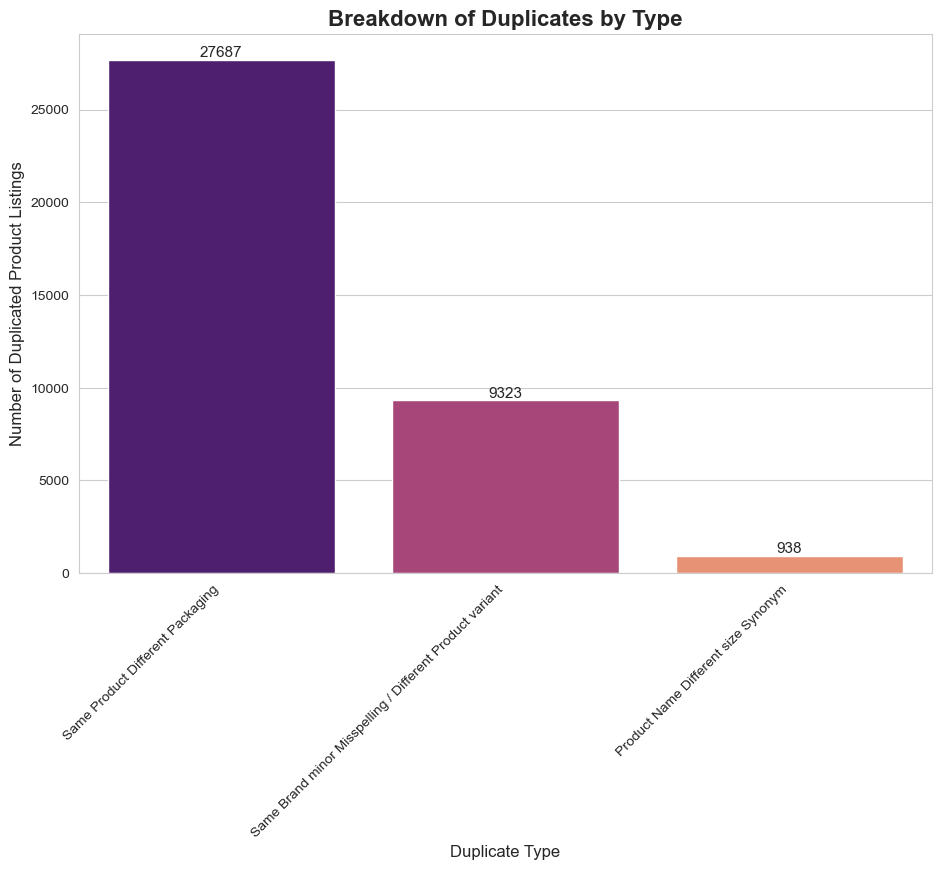

In [892]:
type_counts = all_duplicates_df['duplicate_type'].value_counts()

plt.figure(figsize=(11, 7))
barplot = sns.barplot(x=type_counts.index, y=type_counts.values, palette='magma')
plt.title('Breakdown of Duplicates by Type', fontsize=16, weight='bold')
plt.xlabel('Duplicate Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Duplicated Product Listings', fontsize=12)

for index, value in enumerate(type_counts.values):
    barplot.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=11)

# Show the plot
plt.show()

### Top 10 duplicate product categories

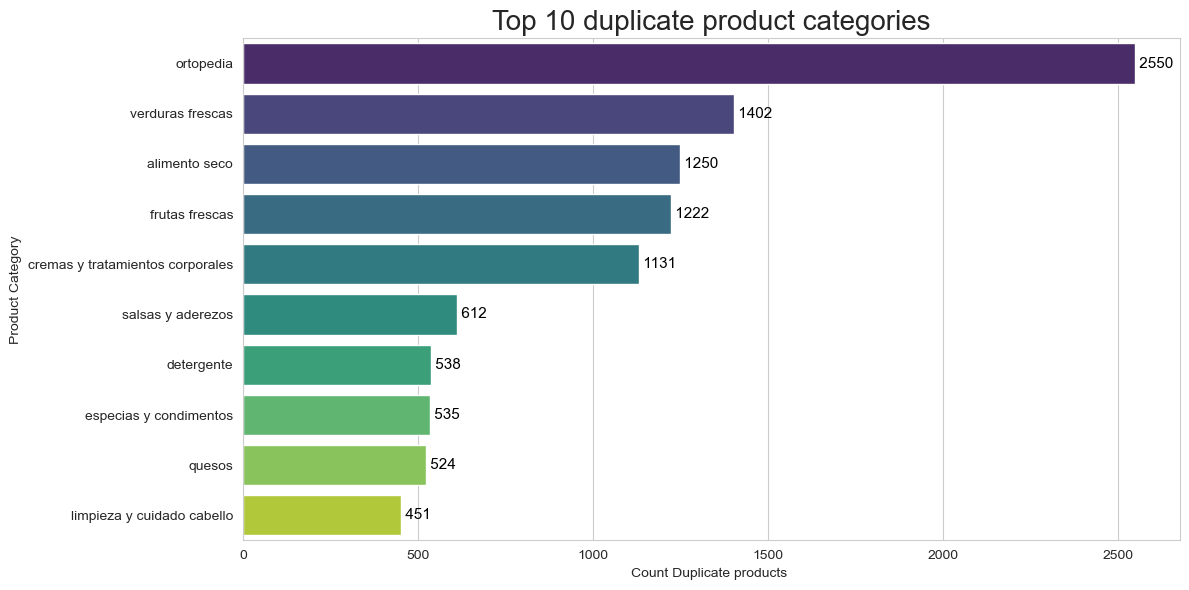

In [893]:
category_top10= all_duplicates_df['category_std'].value_counts().nlargest(10)

plt.figure(figsize=(12,6))
barplot = sns.barplot(x = category_top10.values, y = category_top10.index, palette='viridis')
plt.title('Top 10 duplicate product categories', fontsize = 20)
plt.xlabel('Count Duplicate products ')
plt.ylabel('Product Category')

for index, value in enumerate(category_top10.values):
    plt.text(value, index, f' {value}', va='center', fontsize=11, color='black')

# Ensure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()

### Understanding which duplicates have most orders

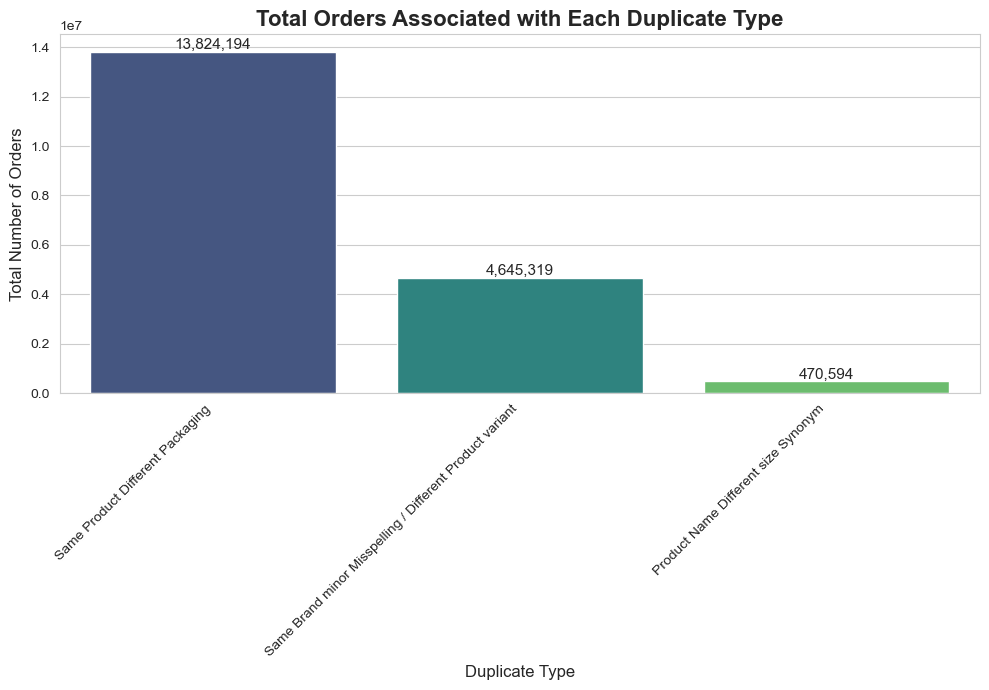

In [894]:
orders_by_type = all_duplicates_df.groupby('duplicate_type')['orders'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 7))
barplot = sns.barplot(x=orders_by_type.index, y=orders_by_type.values, palette='viridis')
plt.title('Total Orders Associated with Each Duplicate Type', fontsize=16, weight='bold')
plt.xlabel('Duplicate Type', fontsize=12)
plt.ylabel('Total Number of Orders', fontsize=12)
plt.xticks(rotation=45, ha='right')


for index, value in enumerate(orders_by_type.values):
    barplot.text(index, value, f'{value:,}', ha='center', va='bottom', fontsize=11) # The :, adds a comma for thousands

plt.tight_layout()
plt.show()

### Top 10 Duplicates for Packaging Variation - Type 1 Duplicates

In [895]:
packaging_duplicates_df = all_duplicates_df[all_duplicates_df['duplicate_type'] == 'Same Product Different Packaging']


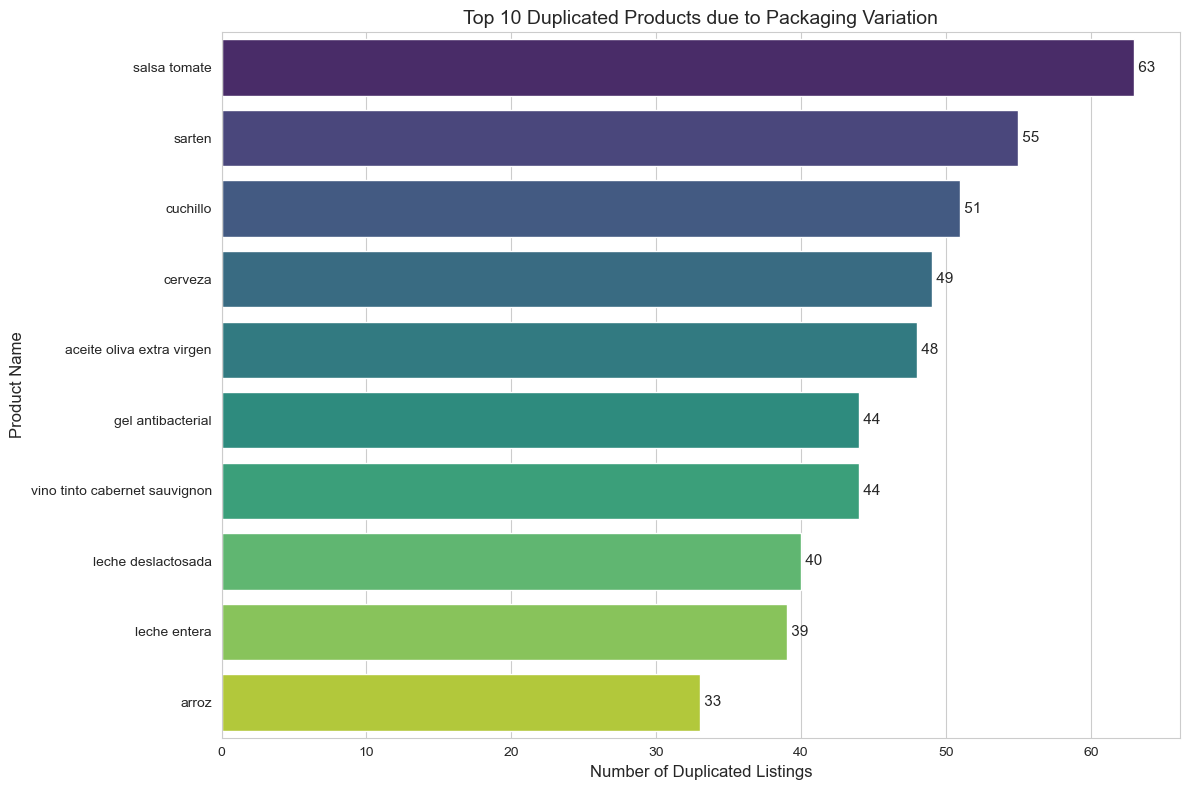

In [896]:
top_10_pack_duplicates = packaging_duplicates_df.groupby('duplicatetype_id').agg(
    representative_name=('product_name_std', 'first'),
    duplicate_count=('product_id', 'count')
).nlargest(10, 'duplicate_count')

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='duplicate_count', y='representative_name', data=top_10_pack_duplicates, palette='viridis')
plt.title('Top 10 Duplicated Products due to Packaging Variation', fontsize=14)
plt.xlabel('Number of Duplicated Listings', fontsize=12)
plt.ylabel('Product Name', fontsize=12)

for index, value in enumerate(top_10_pack_duplicates['duplicate_count']):
    plt.text(value, index, f' {value}', va='center', ha='left', fontsize=11)

plt.tight_layout()
plt.show()

### Top 10 Duplicates for Same Brand Misspelling - Type 2 Duplicates

In [897]:
misspelling_duplicates_df = all_duplicates_df[all_duplicates_df['duplicate_type'] == 'Same Brand minor Misspelling / Different Product variant']


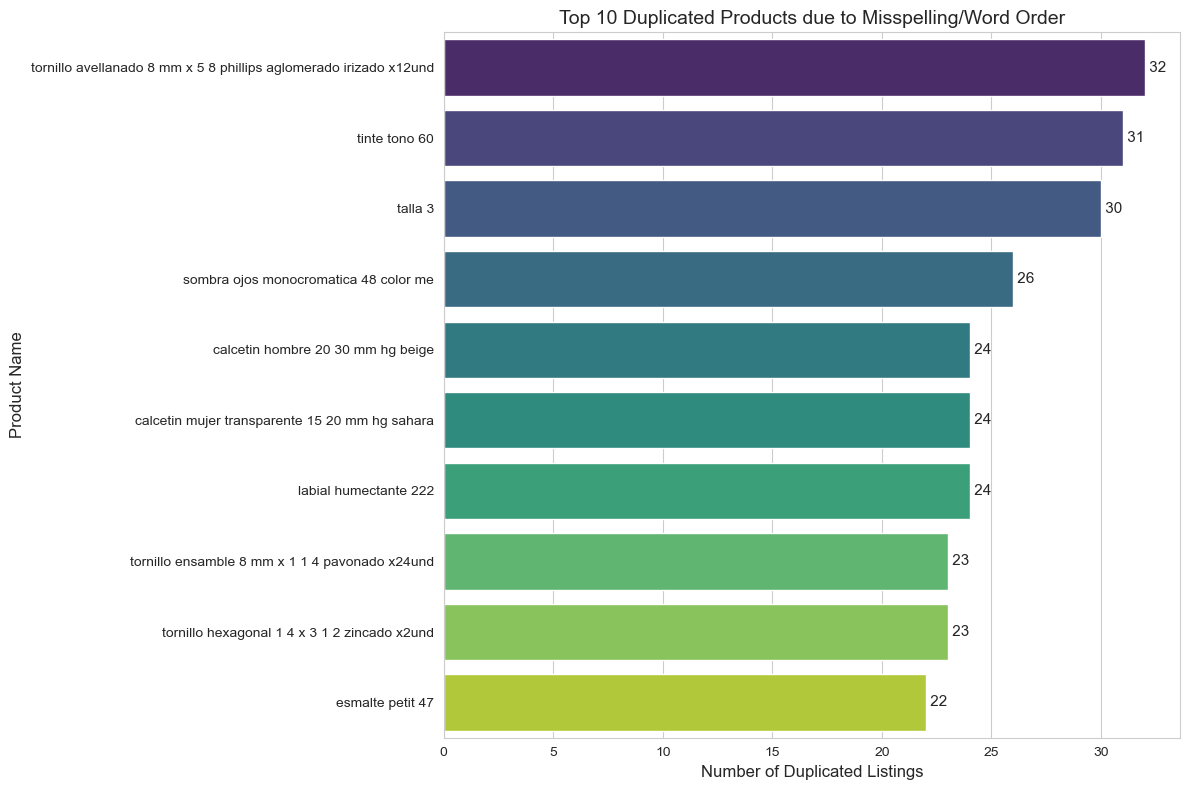

In [898]:
top_10_misspelling_duplicates = misspelling_duplicates_df.groupby('duplicate_id').agg(
    representative_name=('product_name_std', 'first'),
    duplicate_count=('product_id', 'count')
).nlargest(10, 'duplicate_count')


plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='duplicate_count', y='representative_name', data=top_10_misspelling_duplicates, palette='viridis')
plt.title('Top 10 Duplicated Products due to Misspelling/Word Order', fontsize=14)
plt.xlabel('Number of Duplicated Listings', fontsize=12)
plt.ylabel('Product Name', fontsize=12)

for index, value in enumerate(top_10_misspelling_duplicates['duplicate_count']):
    plt.text(value, index, f' {value}', va='center', ha='left', fontsize=11)

plt.tight_layout()
plt.show()

### Top 10 Duplicates for same unit, synonyms for size - Type 3 Duplicates

In [899]:
synonym_duplicates_df = all_duplicates_df[all_duplicates_df['duplicate_type'] == 'Product Name Different size Synonym']

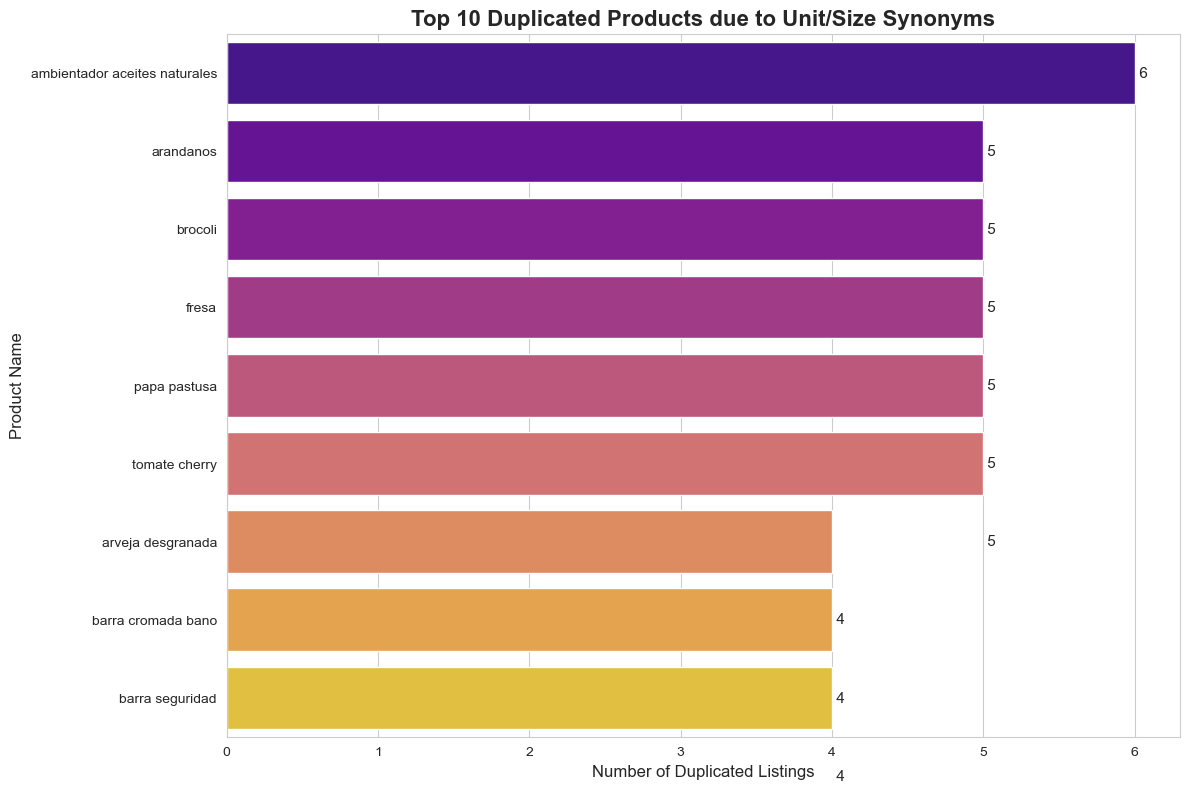

In [900]:
top_10_synonym_duplicates = synonym_duplicates_df.groupby('duplicate_id').agg(
        representative_name=('product_name_std', 'first'),
        duplicate_count=('product_id', 'count')
    ).nlargest(10, 'duplicate_count')

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='duplicate_count', y='representative_name', data=top_10_synonym_duplicates, palette='plasma', orient='h')
plt.title('Top 10 Duplicated Products due to Unit/Size Synonyms', fontsize=16, weight='bold')
plt.xlabel('Number of Duplicated Listings', fontsize=12)
plt.ylabel('Product Name', fontsize=12)

for index, value in enumerate(top_10_synonym_duplicates['duplicate_count']):
        plt.text(value, index, f' {value}', va='center', ha='left', fontsize=11)

plt.tight_layout()
plt.show()

### Before and after cleaning the data visuals

In [904]:
df[['product_name', 'product_name_std']].head(75)

,product_name,product_name_std
0,Atún en aceite,atun aceite
1,Atún en aceite,atun aceite
2,Atún en aceite de girasol,atun aceite girasol
3,Atún en agua,atun agua
4,Atún en agua,atun agua
...,...,...
70,Cerveza light lata,cerveza light lata
71,Pack x12 cerveza andina light lata 330ml,pack x12 cerveza andina light lata 330ml
72,Exterminador cucarachas y hormigas New Andin,exterminador cucarachas hormigas new andin
73,Varsol new andin,varsol new andin


In [786]:
df.head()

,product_id,product_name,buy_unit,package,brand,parent_category_id,category_id,parent_category_name,category_name,orders,product_name_normalized,product_name_std,package_std,brand_std,category_std,canonical_name,similarity_score,Bucket_Type,Action,cleaned_package,same_brand_minor_misspelling,package_qty,package_unit
0,1,Atún en aceite,UN,3 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,262,atun aceite,atun aceite,3 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite 3 un x 160 g c/un,72,Low,Treat as unique / ignore,3 u x 160 g c/u,aceite atun,480.0,g
1,2,Atún en aceite,UN,1730 g,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,387,atun aceite,atun aceite,1730 g,van camp s,carnes y mariscos en conserva,van camp s atun aceite 1730 g,72,Low,Treat as unique / ignore,1730 g,aceite atun,1730.0,g
2,3,Atún en aceite de girasol,UN,4 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,600,atun aceite girasol,atun aceite girasol,4 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun aceite girasol 4 un x 160 g c/un,84,Medium,Send to manual review,4 u x 160 g c/u,aceite atun girasol,640.0,g
3,4,Atún en agua,UN,6 u x 160 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,749,atun agua,atun agua,6 un x 160 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 6 un x 160 g c/un,66,Low,Treat as unique / ignore,6 u x 160 g c/u,agua atun,960.0,g
4,5,Atún en agua,UN,3 u x 80 g c/u,Van Camp's,521,83,Productos en conserva,Carnes y mariscos en conserva,259,atun agua,atun agua,3 un x 80 g c/un,van camp s,carnes y mariscos en conserva,van camp s atun agua 3 un x 80 g c/un,66,Low,Treat as unique / ignore,3 u x 80 g c/u,agua atun,240.0,g


### Showing the Similarity score buckets

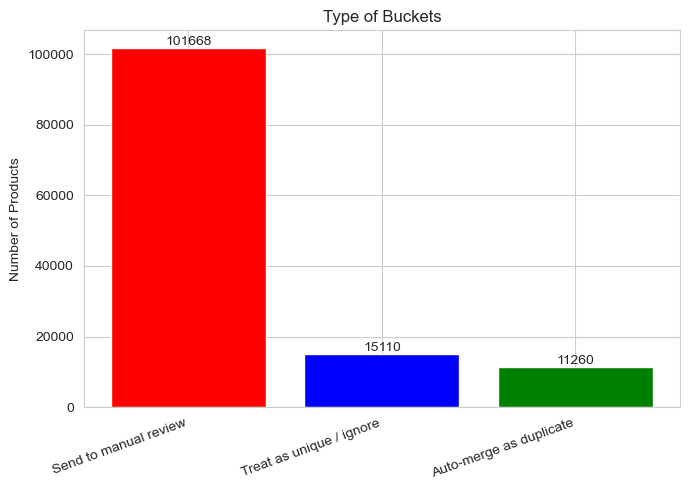

In [790]:
bucket_counts = df["Action"].value_counts()

plt.figure(figsize=(7,5))
bars = plt.bar(bucket_counts.index, bucket_counts.values, color=['red', "blue", 'green'])
plt.title("Type of Buckets")
plt.ylabel("Number of Products")
plt.xticks(rotation=20, ha="right")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f"{int(height):}", ha='center',va='bottom',fontsize=10
    )

plt.tight_layout()
plt.show()

### Merchant training to standardize naming

- My Strategy for this crucial step would be to educate the merchants in a way that we are able to get the first step prioritized before even moving to improving the catalog quality. 
- For this , i would get on a call with them and provide a short demo of how we would want our dataset to be in. Like giving them an example demo would be great because it would help them understand how we interpret the data and that would help us get rid of the columnms that we do not need or that are not relevant to our analysis. 
- We can also provide them real examples like a template or a short spreadsheet of the layout of the naming conventions that we need it in. 
-  if we want it a particular way lets say we just want the brand, product name, product id to be all seperate or atleast ask them to try their best to keep it seperate that would help us reduce duplication by not alot of rows but atleast few rows. 
- Before they upload their data, we can create a validation tool that lets us have a checker list before we even start with the data preprocessing. 
- This will allow us to add in specific rules that we expect from the merchants and that can reduce the initial duplications.
- This will allow us to collab with our Engg teams to be our Merchant pipeline where we have a script ready to be provided to the Merchants that way whenever they enter a SKU/product that is already existing in the system, our system can flag it in real time to them saying that this is a potential duplicate product. 
- We can also provide them with a guide book on how they can follow best practices to ensure that the data they give us is in the format we need it in. 

### Step 6 : Readme

### Project : This is a GenAI-based duplication detection project for Uber's grocery and retail platform. The goal is to identify and resolve duplicate product listings caused by inconsistent naming, unit variations, and minor spelling differences. This ensures a cleaner, more accurate catalog for shoppers, merchants, and couriers.



### Problem statement : Historically, the product data sent by merchants has varied widely in quality. Inconsistent formats, spelling errors, and mismatched packaging descriptions have led to large numbers of duplicates in the catalog. This has caused:
- Extra manual work for the Catalog Ops and Product teams.
- Confusion for shoppers seeing the same product multiple times.
- Missed sales opportunities when the correct product is hard to find.

### Assumptions

I started by normalizing the product_name column so that all text was consistent and easy to compare. This included converting everything to lowercase, removing stop words, cleaning up extra spaces, and handling punctuation or accents. Once the names were cleaned, I standardized other key fields — brand names were mapped to a single canonical version, category names were aligned to a consistent label, and package descriptions were reformatted with uniform units. Finally, I created a standardized product_name that combines the cleaned name, brand, and package details, so comparisons are based on consistent, reliable text instead of messy merchant input.

After that, I standardized the key fields, including brand names, package descriptions (with consistent units), category names, and product names, so everything followed the same format. I also parsed quantities and units from the package field and converted them to a common scale for easier comparison. Once the data was consistent, I calculated similarity scores between products and grouped them into confidence buckets to decide whether each one should be auto-merged, sent for manual review, or left as unique.

### Definition of duplicates

### Type 1 – Same product, different packaging text

Type 1 covers cases where the product is the same but the packaging text is written differently, such as “Atún en aceite – 3 u x 160 g c/u” and “Atún en aceite – 1730 g"

### Type 2 – Same brand, minor misspellings or different variant

Type 2 happens when the brand is the same but there are small spelling changes or slight variant differences, for example “Atún en aceite” vs “Atún en aceite de girasol”. 

### Type 3 – Same unit, synonyms for size

Type 3 includes products with the same net content but expressed in different units, like “3 L” versus “3000 cc”. 

### Similarity Score thresholds

- greater than 95% → Auto-merge as a duplicate
- 75–95% → Needs human review
- <75% → True unique

### Edge Cases

- Multi-pack vs single pack equivalence – Sometimes the total quantity is identical, but the way it’s packaged is different — for example, 6×500 ml versus 3 L. Whether these should be treated as duplicates really depends on the business rules.
</br>

- Same brand but different variant or flavor — the brand is the same, but the product variant changes what it is, such as “Coca-Cola Classic” versus “Coca-Cola Zero”.
</br>

- Generic vs branded products – The product content and size are the same, but one listing is branded and the other is a store or generic label. For example, “Aceite de girasol – 3000 ml” appears under brands like Oleocali, Claro, Súper Precio, and Sonelo. These may look identical but are different SKUs from a business perspective.

### Risks

- The system could merge products that aren’t truly the same — for example, a branded and a generic version of “Aceite de girasol – 3000 ml”, or two similar variants like “Atún en aceite” and “Atún en agua”.
</br>

- It might also miss real duplicates if there are large differences in spelling, translations, or the way the packaging is described.
</br>

- Unit conversion mistakes can happen, such as treating 500 g as the same as 500 ml, which could lead to incorrect merges.
</br>

- Some tricky scenarios, like whether a multi-pack and a single pack should be considered the same product, depend on business rules that aren’t always clearly defined, which can cause inconsistent handling.

### Human in the Loop Workflow

Refer diagram

### How would i fix the catalog errors and reduce duplication?

Here's how i woudld tackle Catalog Duplicates at Uber (Global Scope)

### Step 1 : Catch duplicates before they even enter the catalog

- Start by cleaning and standardizing all product data — converting names to lowercase, removing stop words, and unifying units (e.g., 3 L → 3000 ml, 1 kg → 1000 g) so that we get accurate comparisons.

- Layer 1 – Exact rule-based matching: matched on brand + normalized size + variant to identify clear duplicates, using canonical forms for direct comparison.

- Layer 2 – GenAI/fuzzy matching: applied AI prompt strategy (pack size detection, attribute inference, image validation) to catch messy duplicates such as typos, synonyms, and word order changes.

- Set similarity thresholds: greater than 95% = auto-merge product into the system, 75–95% = manual Ops team review, <80% = True unique.

### Step 2 : Having a "human - zone"

- The similarity score bucket is a great way to keep humans in the loop. It will help us identify all of the products that fall within a specific category for eg : 75-95% zone needs a human review. The other products in other zones can be ignored by humans. 

- This is the step where we play a more important role than the AI in detecting these products that could be missed by the AI. 

- What this will do is that the other two buckets would be done by the AI so it would automatically speed up our process and reduce the human manual tasks. This will help us in precision and speed.

### Step 3 : Removing bad data at the origin

- The strategy behind this step is that we as an Ops team should look to make or set rules in the origin step itself and that we should implement guardrails & clear instructions to the merchant itself. 

- This would make sure we have a set process in place and the merchants would use that as a standard format of data that we need the catalog information in. (For eg : We can give them a standard canonical unit format policy that the merchants need to follow: Liquids -> ml, solid products -> g etc)

- If a new SKU looks 85–95% similar, we show a link-to-existing suggestion with up to three closest matches and highlighted differences—defaulting to the link of the products but allowing a  'Create New' or 'Override' (with a reason). For high-risk categories, we pause publishing until it’s resolved, log every decision to keep improving the matcher

### Step 4 : Live Catalog Improvement 

This is the step where we take everything we built—normalization, standardization, and the human review flow—and clean up the live catalog. We cluster suspected duplicates, re-link inventory and put the rules to apply so that we have a set system. In parallel, we turn on merchant-side guardrails and the ‘Link to existing’ step so the problem doesn’t reappear.

- END OF PROJECT